## Классификация изображений

### План семинара:

1) Обучим сверточную сеть в задаче классификации изображений и посмотрим на полученные фильтры свёрток

2) Добавим аугментацию

3) Усложняем архитектуру сети для улучшения качества

In [1]:
import warnings

import matplotlib.pyplot as plt
import numpy as np 
import torch
import torch.nn.functional as F
import torchvision
from IPython.display import clear_output
from torch import nn, optim
from torchvision import transforms
from tqdm.auto import tqdm, trange

warnings.filterwarnings("ignore")
%matplotlib inline

In [2]:
device = "cuda: 0" if torch.cuda.is_available() else "cpu"
device

'cpu'

# 1. Обучаем свёрточную сеть для задачи классификации изображений

Сегодня будем работать с датасетом [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html), в котором содержатся изображения 10 классов размером 32 на 32 пикселя с тремя каналами. В тренировочной выборке 50000 изображений, а в тестовой 10000. Загрузим его аналогично тому, как мы загружали MNIST на предыдущих занятиях.

In [31]:
transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ]
)

trainset = torchvision.datasets.CIFAR10(
    root="./data", 
    train=True,                             
    download=False, 
    transform=transform
)
valset = torchvision.datasets.CIFAR10(
    root="./data/", 
    train=False,
    download=False, 
    transform=transform
)

train_dataloader = torch.utils.data.DataLoader(
    trainset, 
    batch_size=16,
    shuffle=True, 
    num_workers=1
)
val_dataloader = torch.utils.data.DataLoader(
    valset, 
    batch_size=16,
    shuffle=False, 
    num_workers=1
)

In [37]:
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

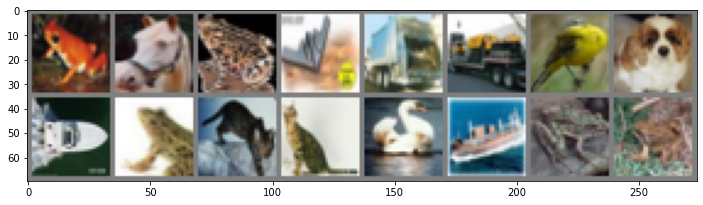

In [42]:
# примеры объектов (достали из одного батча)
images, labels = next(iter(train_dataloader))

plt.figure(figsize=(12,12))
# create grid of images
img_grid = torchvision.utils.make_grid(images)
# show images
matplotlib_imshow(img_grid, one_channel=False)

In [43]:
def plot_history(train_history, val_history, title="loss"):
    plt.figure()
    plt.title('{}'.format(title))
    plt.plot(train_history, label="train", zorder=1)
    
    points = np.array(val_history)
    steps = list(range(0, len(train_history) + 1, int(len(train_history) / len(val_history))))[1:]
    
    plt.scatter(steps, val_history, marker='+', s=180, c="orange", label="val", zorder=2)
    plt.xlabel("train steps")
    
    plt.legend(loc="best")
    plt.grid()

    plt.show()

В качестве бейзлайна возьмем сверточную сеть, состоящую из 1 VGG блока.

VGG блок состоит из двух последовательных сверточных слоев с нелинейностью ReLU между ними, а затем max-pooling. В VGG используются маленькие фильтры размера 3x3 и паддинг

### В качестве бейзлайна постройте следующую архитектуру:

1) VGG блок с 16 каналами:
* свёрточный слой с 16 выходными каналами и ядром 3x3 и нелинейностью ReLU
* свёрточный слой с 16 выходными каналами и ядром 5x5 и нелинейностью ReLU
* Max pooling c ядром 2x2 и шагом 2

2) Полносвязный слой с 128 выходами и нелинейностью ReLU

3) Полносвязный слой с 10 выходами и Softmax

In [82]:
class ModelBaseline(nn.Module):
    def __init__(self):
        """
        В данном методе перечисляются обучаемые  слои нейросети
        """
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1, padding_mode='zeros')
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=16, kernel_size=5, padding=2, padding_mode='zeros')
        # после пуллинга приходит картинка 32//2, 32//2
        # далле нужно "выпрямить" ее перед линейными слоями
        
        self.fc1 = nn.Linear(32//2 * 32//2 * 16, 128)
        self.fc2 = nn.Linear(128,10)
  
    def forward(self, x):
        # x: (batch_size: 16; n_channels: 3 ; hight: 32; width: 32)
        
        out1 = F.relu(self.conv1(x))
        out2 = F.relu(self.conv2(out1))
        out3 = nn.Flatten()(F.max_pool2d(out2, kernel_size=2, stride=2)) 
        out4 = F.relu(self.fc1(out3))
        out5 = F.relu(self.fc2(out4))
        # softmax уже применяется под капотом у CrossEntropyLoss
        
        return out5

In [83]:
# видно, что модель правильно собралась
ModelBaseline()

ModelBaseline(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (fc1): Linear(in_features=4096, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

## Задание: допишите цикл обучения

In [84]:
def train(model, criterion, optimizer, train_dataloader, val_dataloader, n_epochs=5):
    train_loss_log, train_acc_log, val_loss_log, val_acc_log = [], [], [], []
    
    for epoch in range(n_epochs):
        # тренировка
        train_epoch_loss, train_epoch_true_hits = torch.empty(0), torch.empty(0)
        model.train()
        for imgs, labels in tqdm(train_dataloader, desc=f"Training, epoch {epoch}", leave=False):
            imgs, labels = imgs.to(device), labels.to(device)
            
            y_pred = model(imgs)
            loss = criterion(y_pred, labels)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
            # log loss for the current epoch and the whole training history
            train_epoch_loss = torch.cat((train_epoch_loss, loss.unsqueeze(0) / labels.size(0)))
            train_loss_log.append(loss.data / labels.size(0))

            # log accuracy for the current epoch and the whole training history
            pred_classes = torch.argmax(y_pred, dim=-1)
            train_epoch_true_hits = torch.cat((
                train_epoch_true_hits, 
                (pred_classes == labels).sum().unsqueeze(0)
            ))
            train_acc_log.append((pred_classes == labels).cpu().sum() / labels.shape[0])


        # валидация
        val_epoch_loss, val_epoch_true_hits = torch.empty(0), torch.empty(0)
        model.eval()
        with torch.no_grad():
            for imgs, labels in tqdm(val_dataloader, desc=f"Validating, epoch {epoch}", leave=False):
                imgs, labels = imgs.to(device), labels.to(device)
                
                y_pred = model(imgs)
                loss = criterion(y_pred, labels)
                val_epoch_loss = torch.cat((val_epoch_loss, loss.unsqueeze(0) / labels.size(0)))

                pred_classes = torch.argmax(y_pred, dim=-1)
                val_epoch_true_hits = torch.cat((
                    val_epoch_true_hits,
                    (pred_classes == labels).sum().unsqueeze(0)
                ))
        
        
        val_loss_log.append(val_epoch_loss.mean())
        val_acc_log.append(val_epoch_true_hits.sum() / val_epoch_true_hits.size(0) / val_dataloader.batch_size)
        clear_output()
        plot_history(train_loss_log, val_loss_log, "loss")
        plot_history(train_acc_log, val_acc_log, "accuracy")

        print("Train loss:", train_epoch_loss.mean().item())
        print(
            "Train acc:", 
            (train_epoch_true_hits.sum() / train_epoch_true_hits.size(0) / train_dataloader.batch_size).item()
        )
        print("Val loss:", val_epoch_loss.mean().item())
        print(
            "Val acc:", 
            (val_epoch_true_hits.sum() / val_epoch_true_hits.size(0) / val_dataloader.batch_size).item()
        )

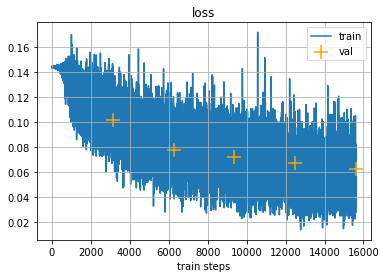

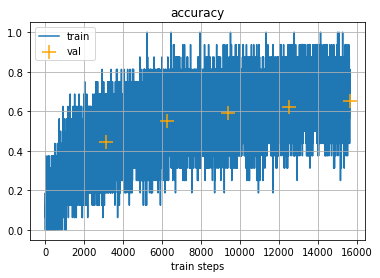

Train loss: 0.05592837557196617
Train acc: 0.6855999827384949
Val loss: 0.0622430294752121
Val acc: 0.6520000100135803


In [85]:
model_baseline = ModelBaseline().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_baseline.parameters(), lr=0.001, momentum=0.9)
   
train(model_baseline, criterion, optimizer, train_dataloader, val_dataloader)

## Визуализируем параметры сети

Для запуска из колаба загрузите в свой google drive файл filter_viz.py и запустите ячейки ниже. При запуске с локальной машины следующую ячейку можно пропустить.

In [ ]:
# import sys
# from google.colab import drive

# drive.mount("/content/gdrive")
# sys.path.append("/content/gdrive/My Drive")

In [87]:
from filter_viz import plot_filters

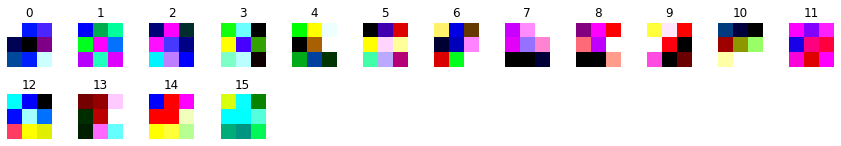

In [90]:
model_baseline.cpu()

plot_filters(model_baseline.conv1, single_channel=False)

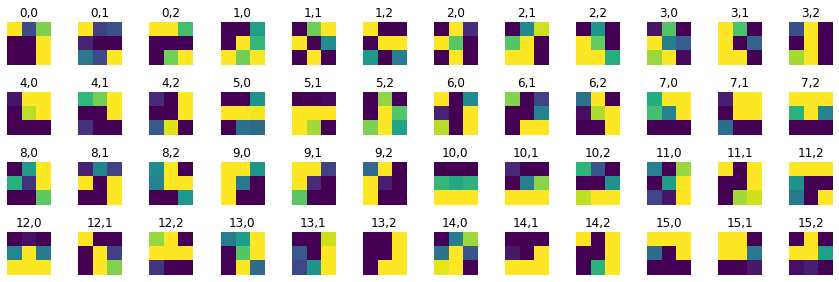

In [91]:
plot_filters(model_baseline.conv1, single_channel=True)

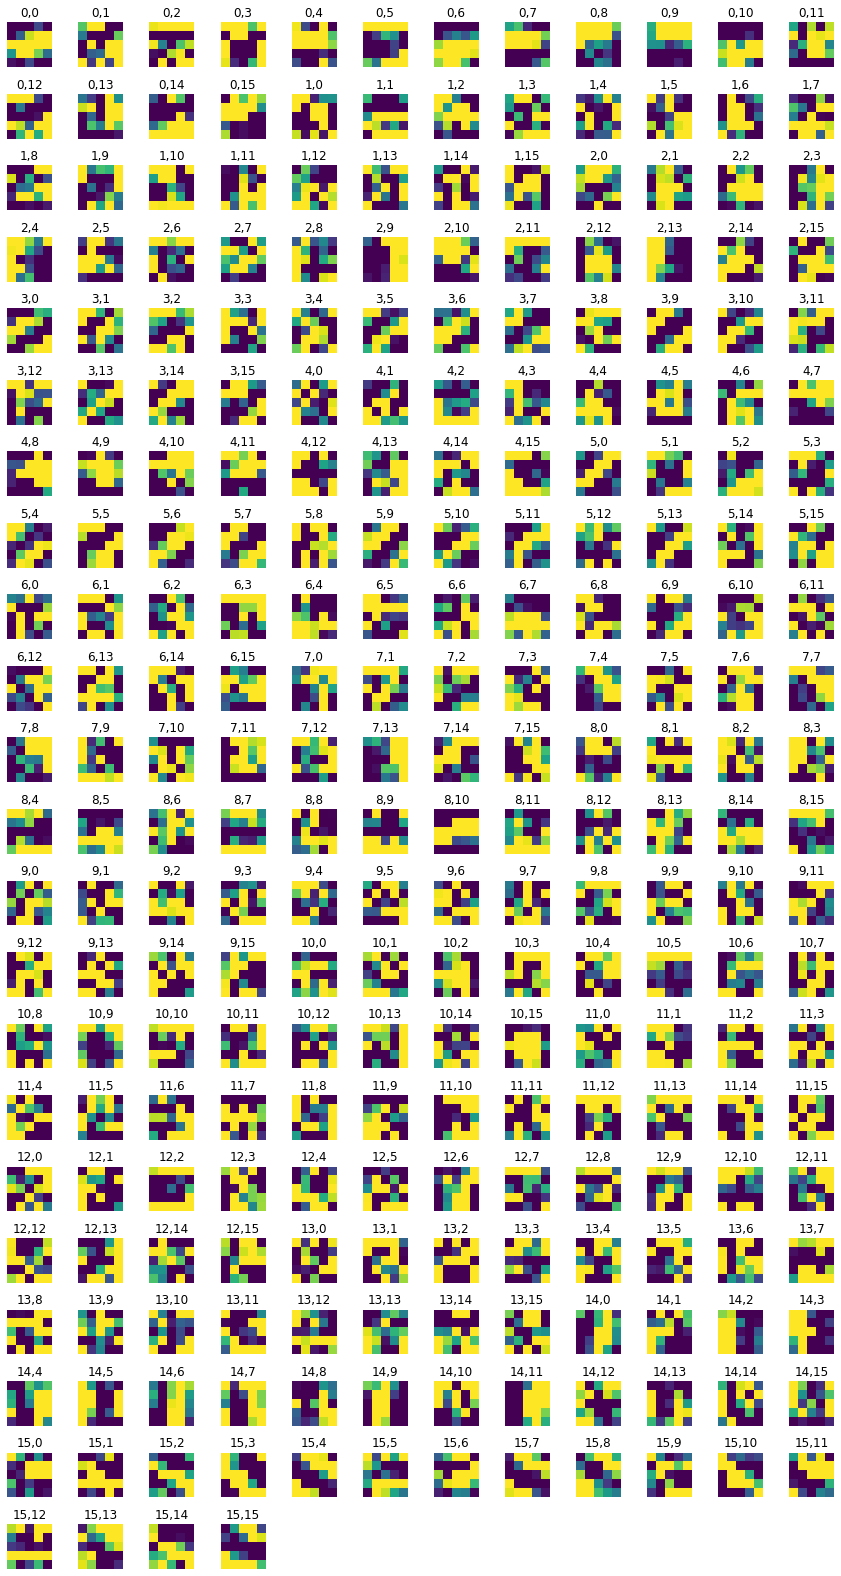

In [92]:
plot_filters(model_baseline.conv2, single_channel=True)

## Задание:

Поэкспериментируйте с функциями активации сети. Попробуйте заменить ReLU на LeakyReLU, ELU или SELU. Как замена влияет на качество и скорость сходимости?

[Почитать про разные функции активации можно здесь](https://mlfromscratch.com/activation-functions-explained/#/)

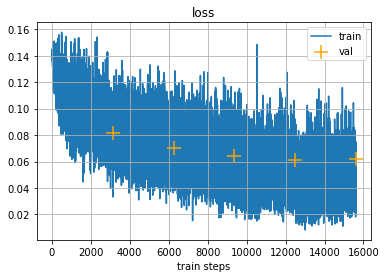

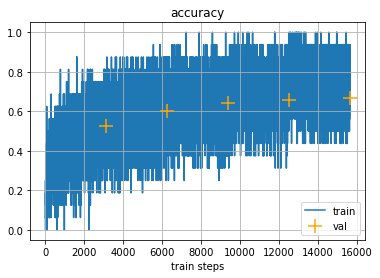

Train loss: 0.04630894586443901
Train acc: 0.7423800230026245
Val loss: 0.06159789860248566
Val acc: 0.6668000221252441


In [93]:
class ModelBaseline(nn.Module):
    def __init__(self):
        """
        В данном методе перечисляются обучаемые  слои нейросети
        """
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1, padding_mode='zeros')
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=16, kernel_size=5, padding=2, padding_mode='zeros')
        # после пуллинга приходит картинка 32//2, 32//2
        # далле нужно "выпрямить" ее перед линейными слоями
        
        self.fc1 = nn.Linear(32//2 * 32//2 * 16, 128)
        self.fc2 = nn.Linear(128,10)
  
    def forward(self, x):
        # x: (batch_size: 16; n_channels: 3 ; hight: 32; width: 32)
        
        out1 = F.elu(self.conv1(x))
        out2 = F.elu(self.conv2(out1))
        out3 = nn.Flatten()(F.max_pool2d(out2, kernel_size=2, stride=2)) 
        out4 = F.elu(self.fc1(out3))
        out5 = F.elu(self.fc2(out4))
        # softmax уже применяется под капотом у CrossEntropyLoss
        
        return out5
        
model_baseline2 = ModelBaseline().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_baseline2.parameters(), lr=0.001, momentum=0.9)

train(model_baseline2, criterion, optimizer, train_dataloader, val_dataloader)

# 2. Аугментация

Аугментация данных - очень мощный процесс, который позволяет увеличить количество тренировочных данных. С помощью поворотов, отражения, добавления шума, сдвигов и других преобразований, картинка немного меняется, однако сохраняет свою прежнюю метку. С помощью функции Compose можно объединять несколько трансформаций изображения, а потом применять их при чтении датасета. Полный список аугментаций доступен [тут](https://pytorch.org/vision/stable/transforms.html). Изучите его и поэкспериментируйте с различными трансформациями изображения

In [115]:
import PIL

transform = transforms.Compose(
    [
        transforms.ColorJitter(hue=.05, saturation=.05),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(20, resample=PIL.Image.BILINEAR),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ]
)

trainset = torchvision.datasets.CIFAR10(
    root="./data/datasets/", 
    train=True,                             
    download=True, 
    transform=transform
)
valset = torchvision.datasets.CIFAR10(
    root="./data/datasets/", 
    train=False,
    download=True, 
    transform=transform
)

train_dataloader = torch.utils.data.DataLoader(
    trainset, 
    batch_size=16,
    shuffle=True, 
    num_workers=1
)
val_dataloader = torch.utils.data.DataLoader(
    valset, 
    batch_size=16,
    shuffle=False, 
    num_workers=1
)

Files already downloaded and verified
Files already downloaded and verified


__Рандомные трансформации объекта/батча происходят на моменте вызова объекта/батча непосредственно из датасета или из даталоадера:__

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


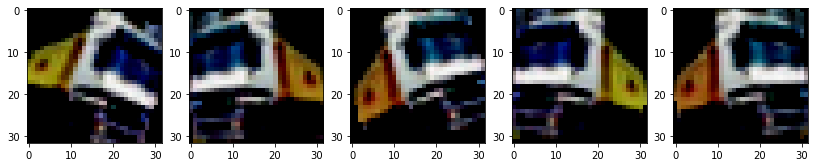

In [138]:
# видно, что при каждом новом вызове с опр вероятностью происходит аугментация
fig, axs = plt.subplots(ncols=5, figsize=(14,7))

for i in range(5):
    axs[i].imshow(trainset[1][0].permute(1,2,0))

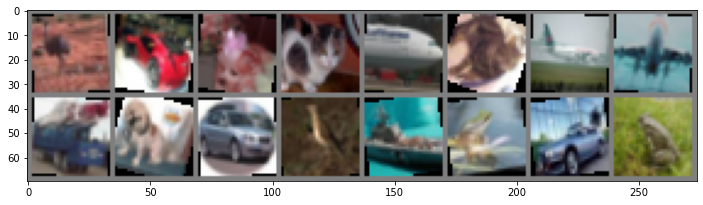

In [139]:
images, labels = next(iter(train_dataloader))

plt.figure(figsize=(12,12))
# create grid of images
img_grid = torchvision.utils.make_grid(images)
# show images
matplotlib_imshow(img_grid, one_channel=False)

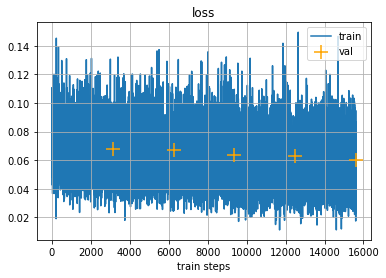

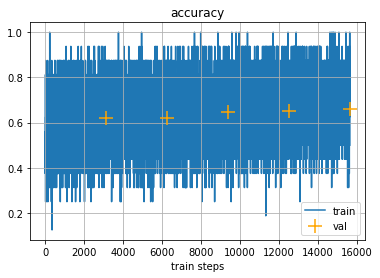

Train loss: 0.05689952149987221
Train acc: 0.6806600093841553
Val loss: 0.06040874496102333
Val acc: 0.6585999727249146


In [140]:
model_base = ModelBaseline().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.S   GD(model_baseline.parameters(), lr=0.001, momentum=0.9)

train(model_baseline, criterion, optimizer, train_dataloader, val_dataloader)

# 3. Как улучшить качество модели?

Особенность VGG блока заключается в том, что повышение качества работы сети достигается увеличением числа последовательных блоков. При этом число фильтров в каждом новом блоке в два раза больше, чем в предыдущем. Давайте попробуем объединить 3 VGG блока.

## **Dropout**

Если сеть имеет сложную архитектуру, то возможно переобучение - процесс, в котором модель слишком сильно подстраивается под тренировочную выборку и потом дает заниженное качество на тестовой. Для борьбы с этим будем использовать Dropout

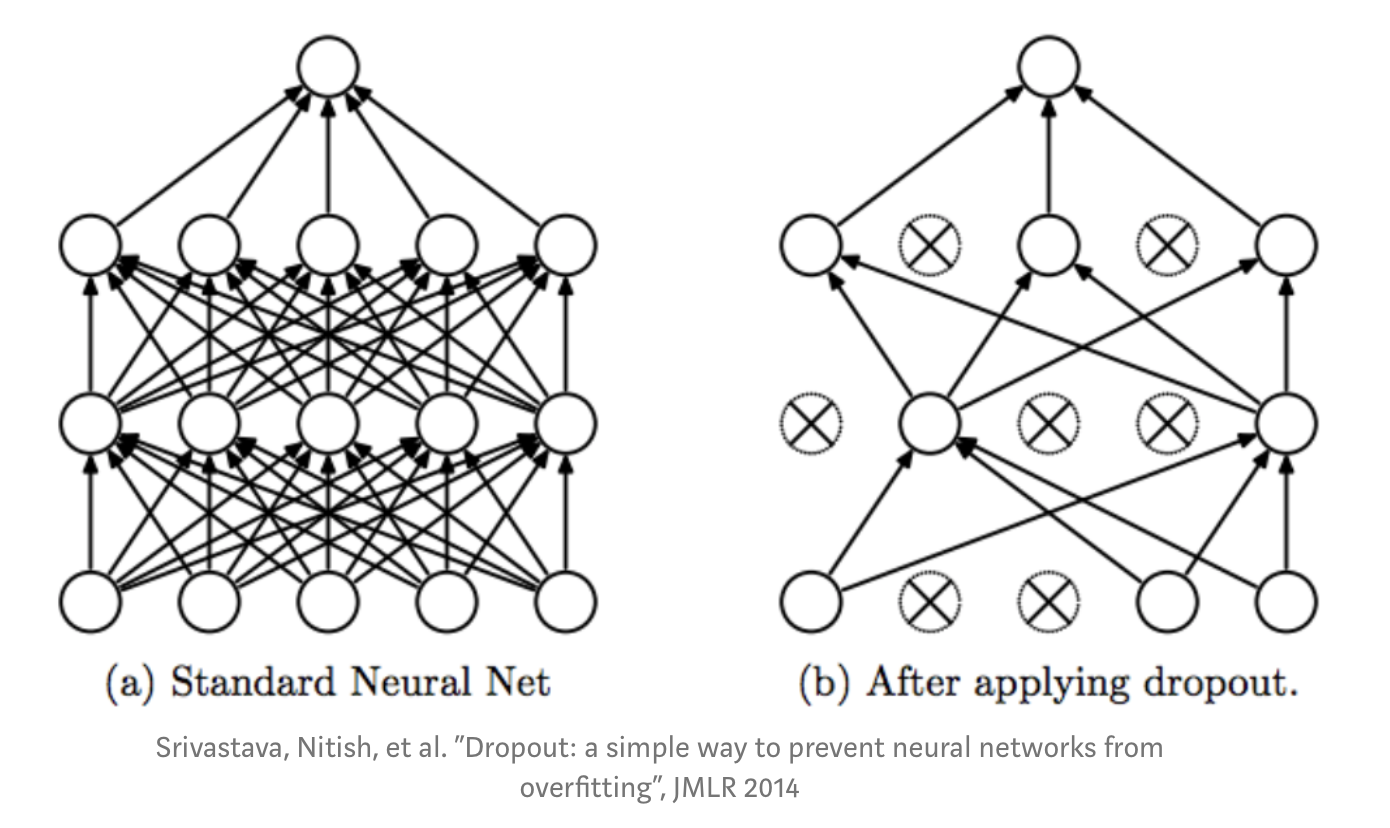

Добавим Dropout с параметром 0.2 после каждого VGG блока и после 1 полносвязного слоя и его нелинейности.

для ускорения и стабилизации обучения добавим [BatchNorm](https://habr.com/ru/post/309302///) после каждого сверточного слоя и после 1 полносвязного слоя
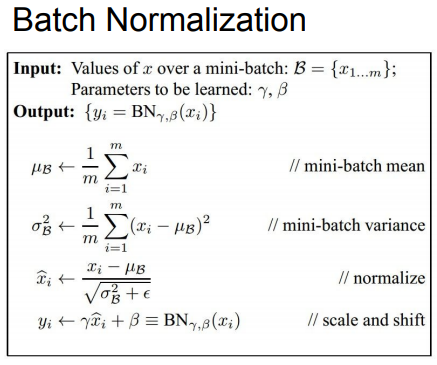


In [141]:
model = nn.Sequential(
    nn.Conv2d(3, 16, 3, padding=1),
    nn.BatchNorm2d(16),
    nn.ReLU(),
    nn.Conv2d(16, 16, 3, padding=1),
    nn.BatchNorm2d(16),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),
    nn.Dropout(0.2),

    nn.Conv2d(16, 32, 3, padding=1),
    nn.BatchNorm2d(32),
    nn.ReLU(),
    nn.Conv2d(32, 32, 3, padding=1),
    nn.BatchNorm2d(32),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),
    nn.Dropout(0.2),

    nn.Conv2d(32, 64, 3, padding=1),
    nn.BatchNorm2d(64),
    nn.ReLU(),
    nn.Conv2d(64, 64, 3, padding=1),
    nn.BatchNorm2d(64),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),
    nn.Dropout(0.2),

    nn.Flatten(),
    nn.Linear(64 * 4 * 4, 128),
    nn.BatchNorm1d(128),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(128, 10),
)

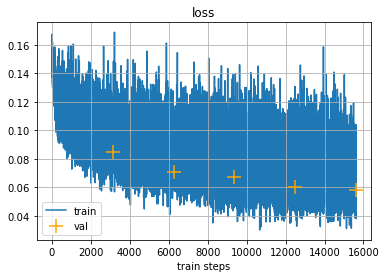

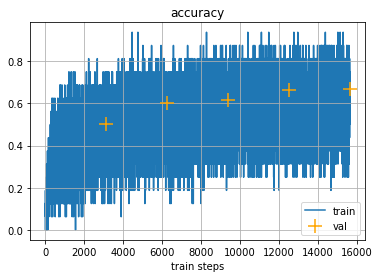

Train loss: 0.07216797024011612
Train acc: 0.595579981803894
Val loss: 0.05832451209425926
Val acc: 0.6672000288963318


In [142]:
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

train(model, criterion, optimizer, train_dataloader, val_dataloader)